Import relevant libraries

In [26]:
import random
from glob import glob
import os
import time
import math

from tqdm import tqdm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom as dicom

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


The input folder contains 4 important information
* stage_2_train_labels.csv - CSV file containing the patient id, bounding boxes and target label
* stage_2_detailed_class_info.csv = CSV file containing the detail informaiton of patientid and the corresponding label
* stage_2_train_images - directory contains train images in DICOM format
* stage_2_test_images - directory contains test images in DICOM format

In [2]:
rootDir='/kaggle/input/rsna-pneumonia-detection-challenge/'
trainImagesDir=rootDir+'stage_2_train_images/'
testImagesDir=rootDir+'stage_2_test_images/'
sampleSubmission=rootDir+'stage_2_sample_submission.csv'
classInfo=rootDir+'stage_2_detailed_class_info.csv'
rsnaLink=rootDir+'GCP Credits Request Link - RSNA.txt'
trainLabels=rootDir+'stage_2_train_labels.csv'
workingDir='/kaggle/working/'
tempDir='/kaggle/temp/'

In [3]:
images_path=glob(trainImagesDir + '*.dcm')
print('Total number images in the training set are {}'.format(len(images_path)))
for name in random.sample(images_path, 5):
    print(name)

Total number images in the training set are 26684
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/59f5be9c-ac10-4e11-ba2e-2405568b3af4.dcm
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/e2ff4938-8485-41f5-b35b-ce6a81a6f93e.dcm
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/bd3be67d-192e-4cfc-91e3-381fc8465019.dcm
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/17c67743-6d92-4dda-adae-61bc41724da4.dcm
/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/1794b7b4-de8c-479a-bfa7-2ab868c3061b.dcm


The image names are stored with patientId

In [4]:
image_target=pd.read_csv(trainLabels)
image_target.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


The CSV file contains PatientId, bounding box details with (x,y) coordinates and width and height that encapsulates the box. It also contains the Target variable. For target variable 0, the bounding box values has NaN values.


In [5]:
print(image_target.shape)

(30227, 6)


There are only 26684 images in the image directory, but the csv file contains 30227 rows. There are more rows than the images, which indicates there are duplicate entries for patientId

We can observe row #4 and #5, row #8 and #9 have same patientId values, aka, the patient is identified with pneumonia at multiple areas

In [6]:
image_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


For the info of the data, we observe that of the total 30227 rows, 9555 rows has non null. So, all bounding boxes are either defined or not defined.

In [7]:
print(image_target[image_target.Target==0].shape[0])
print(image_target[image_target.Target==1].shape[0])

20672
9555


We see from above that the total number of patientIds that are identified with Pneumonia are 9555 and it matches to the non null values. It can be inferred from this that all pneumonia data set has bounding boxes defined and for normal patients, no bounding boxes exist.

In [8]:
image_target.Target.unique()

array([0, 1])

The target has two classifications 0 and 1 namely Normal and Pneumonia

In [9]:
def update_dataset(path, df1):
    pid=[]
    label=[]
    bbox=[]

    for name, group in df1.groupby(['patientId','Target']):
        pid.append(path+group['patientId'].tolist()[0]+'.dcm')
        label.append(group['Target'].tolist()[0])
        if group['Target'].tolist()[0] == 1:
            ibbox=[]
            for row in group.iterrows():
                ibbox.append([row[1]['x'], row[1]['y'], row[1]['width'], row[1]['height']])
            bbox.append(ibbox)
        else:
            bbox.append([])
    df = pd.DataFrame({'patientId':pid, 'bboxes': bbox, 'label':label})
    return df

We can observe that the non-null values are 9555 which matches to the patients that have pneumonia problem

In [10]:
df=update_dataset(trainImagesDir, image_target)
print(df.shape)
df.head()

(26684, 3)


,patientId,bboxes,label
0,/kaggle/input/rsna-pneumonia-detection-challen...,[],0
1,/kaggle/input/rsna-pneumonia-detection-challen...,[],0
2,/kaggle/input/rsna-pneumonia-detection-challen...,"[[316.0, 318.0, 170.0, 478.0], [660.0, 375.0, ...",1
3,/kaggle/input/rsna-pneumonia-detection-challen...,"[[570.0, 282.0, 269.0, 409.0], [83.0, 227.0, 2...",1
4,/kaggle/input/rsna-pneumonia-detection-challen...,"[[66.0, 160.0, 373.0, 608.0], [552.0, 164.0, 3...",1


In [11]:
print('Total number of patients that are normal are {}'.format(df[df.label==0].shape[0]))
print('Total number of patients that have pneumonia are {}'.format(df[df.label==1].shape[0]))

Total number of patients that are normal are 20672
Total number of patients that have pneumonia are 6012


In [12]:
imgWidth=224
imgHeight=224
imgChannels=3
imgSize=(imgHeight, imgWidth)
batchSize=64
labelDict={0:'normal', 1:'lung opacity'}

In [13]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except ValueError:
#     strategy = tf.distribute.get_strategy() # for CPU and single GPU
#     print('Number of replicas:', strategy.num_replicas_in_sync)

In [14]:
print('Maximum number of areas detected for Pneumonia are {}'.format(max([len(x) for x in df.bboxes])))

Maximum number of areas detected for Pneumonia are 4


In [15]:
def loadImages(df):
    cols=5
    rows=4
    idx=0
    f,axarr=plt.subplots(rows,cols,figsize=(18,10))
    data=df.sample(n = cols*rows)
    for r in range(rows):
        for c in range(cols):
            image_path = df.patientId[idx]
            img = dicom.dcmread(image_path).pixel_array
            axarr[r,c].imshow(img, cmap='gray')
            lbl=labelDict.get(df.label[idx])
            bboxes=df.bboxes[idx]
            for bbox in bboxes:
                x=bbox[0]
                y=bbox[1]
                w=bbox[2]
                h=bbox[3]
                rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='red', fill=False)
                axarr[r,c].add_patch(rect)

            axarr[r,c].set_title(lbl)
            idx+=1
    plt.tight_layout()

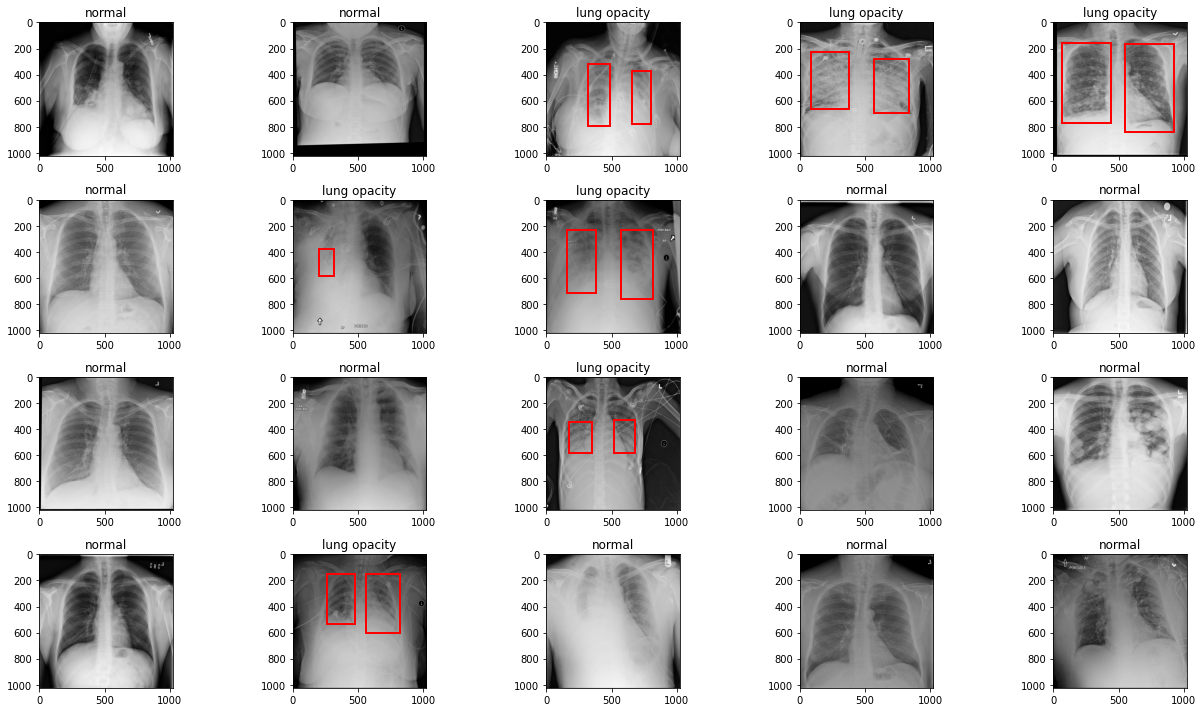

In [16]:
loadImages(df)

In [17]:
def check_images_shape(path):
    img_path=glob(path + '*.dcm')
    imagesShape=[dicom.dcmread(image).pixel_array.shape for image in tqdm(img_path)]
    print(set(imagesShape))


In [18]:
# with strategy.scope():
check_images_shape(trainImagesDir)

100%|██████████| 26684/26684 [07:44<00:00, 57.48it/s]

{(1024, 1024)}


All the images are of size 1024*1024

Even though the size of the images are same, we can observe the image inside have different aspect ratio, that is, not all images occupy the same space. Also, the brightness is different.

In [19]:
c=math.ceil(df.shape[0]*0.7)
train_df,val_df=df[:c],df[c:]
print(train_df.shape, val_df.shape)

(18679, 3) (8005, 3)


In [20]:
class CustomDataGen(Sequence):
    
    def __init__(self, df, x_col, y_col, batch_size, input_size=(224, 224), shuffle=True):
        self.df = df.copy(deep=True)
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.n_class = df[y_col['output1']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, img_path, size):
        image = dicom.dcmread(img_path).pixel_array
        org_size=image.shape
        image = cv2.resize(image,(size[0],size[1]))
        image = np.stack([image] * 3, axis=2)
        return preprocess_input(image), org_size
    
    def __get_output0(self, y):
        return y
    
    def __get_output1(self, y, img_size, target_size):
        if y[0]==0:
            return y
        else:
            x=float(y[0])
            y=float(y[1])
            w=float(y[2])
            h=float(y[3])
            xmin=math.ceil(x*target_size[1]/img_size[1])
            ymin=math.ceil(y*target_size[0]/img_size[0])
            xmax=math.ceil((x+w)*target_size[1]/img_size[1])
            ymax=math.ceil((y+h)*target_size[0]/img_size[0])
            width = xmax-xmin
            height = ymax-ymin
            return list([xmin, ymin, width, height])
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.x_col['input']]

        class_batch = batches[self.y_col['output1']]
        bbox_batch = batches[self.y_col['output2']]

        img_batch = [self.__get_input(x, self.input_size) for x in path_batch]
        
        x_batch = [x[0] for x in img_batch]
        img_org_size = [x[1] for x in img_batch]
        y0_batch = [self.__get_output0(y0) for y0 in class_batch]
        y1_batch = [self.__get_output1(y1, org_size, self.input_size) for y1, org_size in zip(bbox_batch, img_org_size)]

        return np.asarray(x_batch), np.asarray(y0_batch)
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        x, y = self.__get_data(batches)
        return x, y
    
    def __len__(self):
        return self.n // self.batch_size
    


In [21]:
traingen = CustomDataGen(train_df,
                         x_col={'input':'patientId'},
                         y_col={'output1': 'label', 'output2': 'bboxes'},
                         batch_size=batchSize, input_size=(imgSize)
                        )

valgen = CustomDataGen(val_df,
                         x_col={'input':'patientId'},
                         y_col={'output1': 'label', 'output2': 'bboxes'},
                         batch_size=batchSize, input_size=(imgSize)
                        )


In [22]:
def loadVGG16(freezelayers=16):
    pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=(imgHeight, imgWidth, 3))
 
    for layer in pretrained_model.layers[:freezelayers]:
        layer.trainable = False
 
    for layer in pretrained_model.layers[freezelayers:]:
        layer.trainable = True

    last_layer = pretrained_model.get_layer(index=len(pretrained_model.layers)-1)
    last_output = last_layer.output

    x = Flatten()(last_output)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    o1 = Dense(1, activation='sigmoid')(x)
#     o2 = Dense(4, activation='relu')(x)
  
    model = Model(pretrained_model.input, o1)
    
    return model

In [23]:
model=loadVGG16()
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [24]:
model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [27]:
try:
    start=time.time()
    model.fit(  traingen,
                validation_data = valgen,
                epochs=5,
                batch_size=64
            )
    print('Time taken:',time.time()-start)
except Exception as e:
    print(e)

list index out of range
